<a href="https://colab.research.google.com/github/NataliaKolesnik/Car_Price_prediction_part2/blob/master/3_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install -U pymorphy2-dicts-ru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
path_data = '/content/drive/MyDrive/SF_project_8/data/'

##Библиотеки

In [5]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import pymorphy2

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, concatenate, LSTM, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import PIL # Pillow — библиотека для работы с изображениями 
import cv2

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)

SEED = 73

FONT_TITLE = 25
FONT_LABEL = 15

## Загрузка и подготовка данных для обучения

In [7]:
df_train = pd.read_csv(path_data+'train_for_ML.csv')
df_test = pd.read_csv(path_data+'test_for_ML.csv')

In [8]:
# Списки с признаками

categorical_features = ['bodyType', 'brand', 'color_littel', 'fuelType_littel', 'model_info',
                        'vehicleTransmission', 'ПТС', 'Привод', ]

numerical_features = ['mileage', 'age_avto', 'engineDisplacement', 'enginePower_log', 'numberOfDoors', 'Владельцы']

text_features = 'description'

target = 'price'
target_log = 'price_log'

In [9]:
# Добавим признак - разделитель для обучающего и тестового датасета 
df_train['sample'] = 1
df_test['sample'] = 0
df_test['price'] = 0

In [10]:
# объединим данные в один датасет для совместной дообработки признаков
df_join = pd.concat([df_train[numerical_features + categorical_features + [text_features, target, 'sample'] ],
                     df_test[numerical_features + categorical_features + [text_features, target, 'sample'] ]])

In [11]:
df_join.head(3)

,mileage,age_avto,engineDisplacement,enginePower_log,numberOfDoors,Владельцы,bodyType,brand,color_littel,fuelType_littel,model_info,vehicleTransmission,ПТС,Привод,description,price,sample
0,245000,14,3.00,5.61,4,3,седан,BMW,чёрный,бензин,5ER,автоматическая,Оригинал,полный,Авто на бодром ходу. Все работает отлично. П...,599000.00,1
1,183000,10,2.80,5.32,4,2,седан,AUDI,серый,бензин,A6,вариатор,Оригинал,передний,"Продажа от собственника, второй владелец, ПТС ...",850000.00,1
2,122733,8,3.50,5.72,4,3,седан,MERCEDES,чёрный,бензин,E_KLASSE,автоматическая,Оригинал,полный,Внимание! Только для клиентов AVILON Автомобил...,1325000.00,1


## Кодирование категориальных признаков

In [12]:
df_join = pd.get_dummies(df_join, columns=categorical_features, dummy_na=False)


## Разбиение датасета на обучающий, валидационный и тестовый для model_mlp

In [13]:
train = df_join.query('sample == 1').drop(['sample'], axis=1)
X_test = df_join.query('sample == 0').drop(['sample'], axis=1)

Y = train.price.values     # наш таргет
X = train.drop(['price', text_features], axis=1)
X_test = X_test.drop(['price', text_features], axis=1)

### Стандартизация числовых признаков

In [14]:
# Стандартизируем числовые данные

scaler = MinMaxScaler()

X[numerical_features] = scaler.fit_transform(X[numerical_features])
X_test[numerical_features] = scaler.fit_transform(X_test[numerical_features])

In [15]:
X.describe()

,mileage,age_avto,engineDisplacement,enginePower_log,numberOfDoors,Владельцы,bodyType_внедорожник,bodyType_кабриолет,bodyType_купе,bodyType_купе-хардтоп,...,model_info_Z8,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,ПТС_Дубликат,ПТС_Оригинал,Привод_задний,Привод_передний,Привод_полный
count,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,...,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00
mean,0.12,0.21,0.42,0.54,0.76,0.55,0.35,0.01,0.06,0.01,...,0.00,0.79,0.05,0.02,0.14,0.11,0.89,0.27,0.11,0.63
std,0.08,0.13,0.16,0.18,0.29,0.42,0.48,0.08,0.24,0.12,...,0.01,0.41,0.22,0.14,0.35,0.31,0.31,0.44,0.31,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.06,0.11,0.30,0.42,0.67,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
50%,0.11,0.18,0.42,0.53,0.67,0.50,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
75%,0.17,0.29,0.45,0.66,1.00,1.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [16]:
X_test.describe()

,mileage,age_avto,engineDisplacement,enginePower_log,numberOfDoors,Владельцы,bodyType_внедорожник,bodyType_кабриолет,bodyType_купе,bodyType_купе-хардтоп,...,model_info_Z8,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,ПТС_Дубликат,ПТС_Оригинал,Привод_задний,Привод_передний,Привод_полный
count,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,...,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00
mean,0.12,0.21,0.42,0.44,0.75,0.55,0.35,0.01,0.07,0.01,...,0.00,0.78,0.05,0.03,0.14,0.10,0.90,0.28,0.10,0.62
std,0.08,0.14,0.16,0.19,0.30,0.41,0.48,0.08,0.25,0.11,...,0.00,0.42,0.21,0.17,0.35,0.30,0.30,0.45,0.30,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.06,0.11,0.30,0.31,0.67,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
50%,0.11,0.18,0.41,0.43,0.67,0.50,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
75%,0.17,0.29,0.45,0.57,1.00,1.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [17]:
# Разбиваем на обучающую и валидационную выборки
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=SEED, shuffle=True)

In [18]:
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_valid:', X_valid.shape, 'Y_valid:', Y_valid.shape)
print('X_test: ', X_test.shape)

X_train: (5345, 159) Y_train: (5345,)
X_valid: (1337, 159) Y_valid: (1337,)
X_test:  (1671, 159)


## Работа с текстом в колонке description

In [19]:
df_join.description.iloc[15]

'。Преднатяжители ремней безопасности\n。Крепление для детского сиденья ISOFIX\n。Подушка безопасности пассажира с функцией деактивации\n。Система динамической регулировки тяги\n。Система контроля давления в шинах\n。Безопасные шины Runflat\n。Рекуперация энергии торможения\n。Обивка салона - Кожа Dakota\n。Автоматическая коррекция угла наклона фар\n。Функция Auto Start Stop\n。Кнопка запуска/остановки двигателя\n。Сервотроник\n。Передние и задние парктроники\n。Обогрев боковых зеркал\n。Радио BMW Professional CD (CD-проигрыватель,Поддержка MP3, 8 и более динамиков,Многофункциональный цветной дисплей)\n。Разъем для подключения внешнего аудиоустройства\n。Навигационная система с жестким диском\n。Коммуникационная система Bluetooth\n\n☛ Все заявленные автомобили находятся в наличии.\n☛ Два комплекта ключей.\n☛ Выгода по программе Trade-In до 70 тысяч рублей.\n☛ Выгода в кредит до 80 тысяч рублей.\n\n\n▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼\n\n                       Условия при покупке автомобиля в кредит:\n\n➥ С

В данных куча мусор. С помощью регулярных выражений оставим только слова, состоящие из 3 и более букв. 

In [20]:
df_join['text'] = df_join['description'].apply(lambda s: re.sub(r'\d+', '', s))
df_join['text'] = df_join['text'].apply(lambda s: re.split(r'\W+', s))


In [21]:
# приведемм слова разммером более 2 букв к леммам 

morph = pymorphy2.MorphAnalyzer()

def lem(x):
    x = [morph.parse(w)[0].normal_form for w in x if len(w)>1 ]
    return x

df_join['text_lem'] = df_join['text'].apply(lem)

In [22]:
# посчитаем количество уникальных слов и частоту встречаемости каждого слова

count_words = {}

for i in range(df_join.shape[0]):
    text = df_join['text_lem'].iloc[i]

    for el in text:
        if el in count_words.keys():
            count_words[el] += 1
        else:
            count_words[el] = 1

In [23]:
# Создадим датафрейм частотности слов, учтоб удобно проанализировать какие сова можно убрать

df_words = pd.DataFrame(count_words, index = ['count']).T

In [24]:
print(f'Всего {df_words.shape[0]} уникальный слов от 2-х букв и более')

Всего 17947 уникальный слов от 2-х букв и более


In [25]:
# Из них тех, которые встречаюстя 1-3 раза. 

df_words[df_words['count']<=3]['count'].value_counts()

1    8292
2    2159
3    1028
Name: count, dtype: int64

In [26]:
# Особо часто встречающиеся
df_words[df_words['count']>4000]['count'].sort_values()

до             4046
от             4198
машина         4561
передний       4764
для            4927
состояние      5270
год            5322
сидение        5872
салон          5959
задний         6250
всё            6349
пробег         6403
система        9045
по            10043
не            10673
на            15600
автомобиль    17352
Name: count, dtype: int64

In [27]:
# Список слов для обучения с частотой встречаемостии более 3-х раз
word_for_train = list(df_words[df_words['count']>3].index)

In [28]:
# Удалим редко встречающиеся слова из описания

def word_train(x):
    new_list_word = []
    for el in x:
        if el in word_for_train:
            new_list_word.append(el)
    return new_list_word

df_join['text_lem_train'] = df_join['text_lem'].apply(word_train)

In [29]:
# Создадим и обучим токенайзер
num_words = len(word_for_train)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_join['text_lem_train'])

In [30]:
items = list(tokenizer.word_index.items())
print(items[260:280])

[('тыс', 261), ('поменять', 262), ('предлагать', 263), ('продать', 264), ('автосалон', 265), ('колодка', 266), ('под', 267), ('зима', 268), ('страна', 269), ('также', 270), ('продаваться', 271), ('самый', 272), ('который', 273), ('навигация', 274), ('certified', 275), ('реальный', 276), ('аварийный', 277), ('никакой', 278), ('перед', 279), ('обслужить', 280)]


### Делим подготовленный текст на выборки и формируем датасеты для подачи в model_nlp

In [31]:
train_text = df_join.query('sample == 1')[['text_lem_train']]
X_test_text = df_join.query('sample == 0')[['text_lem_train']]

In [32]:
X_train_text = df_join.iloc[X_train.index]
X_valid_text = df_join.iloc[X_valid.index]

In [33]:
print('X_train_text:', X_train_text.shape)
print('X_valid_text:', X_valid_text.shape)
print('X_test_text: ', X_test_text.shape)

X_train_text: (5345, 165)
X_valid_text: (1337, 165)
X_test_text:  (1671, 1)


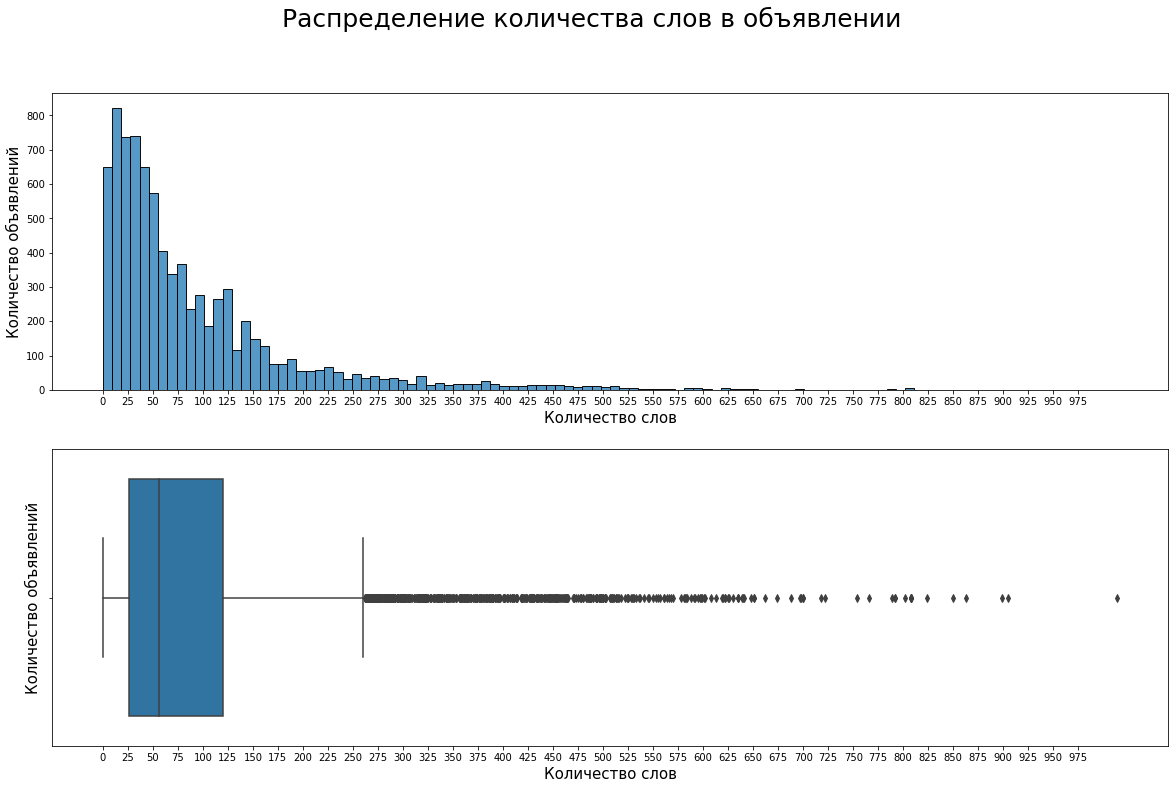

In [34]:
fig, ax = plt.subplots(2,1, figsize=(20,12))
plt.suptitle('Распределение количества слов в объявлении', fontsize=FONT_TITLE)

sns.histplot(data=df_join['text_lem_train'].apply(len), ax=ax[0])
ax[0].set_xlabel('Количество слов', fontsize=FONT_LABEL)
ax[0].set_ylabel('Количество объявлений', fontsize=FONT_LABEL)
ax[0].set_xticks([x for x in range(0, 1000, 25)])

sns.boxplot(x=df_join['text_lem_train'].apply(len), ax=ax[1])
ax[1].set_xlabel('Количество слов', fontsize=FONT_LABEL)
ax[1].set_ylabel('Количество объявлений', fontsize=FONT_LABEL)
ax[1].set_xticks([x for x in range(0, 1000, 25)])
plt.show()

Длину текста объявления оптимально будет выбирать от 125 до 150 слов.

In [35]:
MAX_SEQUENCE_LENGTH = 200

train_sequences = tokenizer.texts_to_sequences(X_train_text['text_lem_train'])

X_train_text_num = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

vaid_sequences = tokenizer.texts_to_sequences(X_valid_text['text_lem_train'])

X_valid_text_num = pad_sequences(vaid_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(X_test_text['text_lem_train'])

X_test_text_num = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [36]:
X_train_text.iloc[150]

mileage                                                          162000
age_avto                                                             18
engineDisplacement                                                 3.00
enginePower_log                                                    5.44
numberOfDoors                                                         4
                                            ...                        
Привод_передний                                                       0
Привод_полный                                                         0
text                  [Продается, бронированный, автомобиль, BMW, E,...
text_lem              [продаваться, бронировать, автомобиль, bmw, за...
text_lem_train        [продаваться, бронировать, автомобиль, bmw, за...
Name: 671, Length: 165, dtype: object

In [37]:
X_train_text_num[150]

array([ 271, 2000,    1,   43,  321,  660, 5911,    1,  800, 1947,  321,
       3002,  508, 2000,   79,  504,  321, 2765,    9,  107,   67,   12,
          9,  491,  158,  321, 2192,  504,  158, 1090,  422, 1594,   64,
         37,  146,   80,   59,    8,  266,  363,   37,  282, 1051,   11,
        618,  132, 1427,  296,   11,  825,    3,  618,  341, 1670,   91,
       3778, 2174,    1, 4952,  800,  976,  855,    4,   68,  533,   94,
        181, 3391,    8,  407,  398,  537,  211, 3505,   14,  490,   81,
        398,  450,  481,    3,  776,    2,  333, 2663,  592,   34,   97,
        255,  110,    3,    7,  903, 4152,    2,  193,    1, 2522,   18,
       1873,  343,  983,   34, 2903, 1136,   13,  291,   13,   91,  451,
       5798,  124,    2,  376,  688,  588, 1088, 1277,    2, 1008,  540,
        765,  132, 1146,  618,   91, 1652,   37,  735,    2,  234,  271,
         36, 2904,  236,  938,   43,  508, 2765,  379,    1,   37,  139,
          4,   43,  875,   11, 1900,  122, 1947,   

## Работа с изображениями

In [38]:
path_img = '/content/drive/MyDrive/SF_project_8/data/img/img/'

# sell_id - содержит номер файла изображения
X_train_img = df_train['sell_id'].iloc[X_train.index]
X_valid_img = df_train['sell_id'].iloc[X_valid.index]
X_test_img = df_test['sell_id']

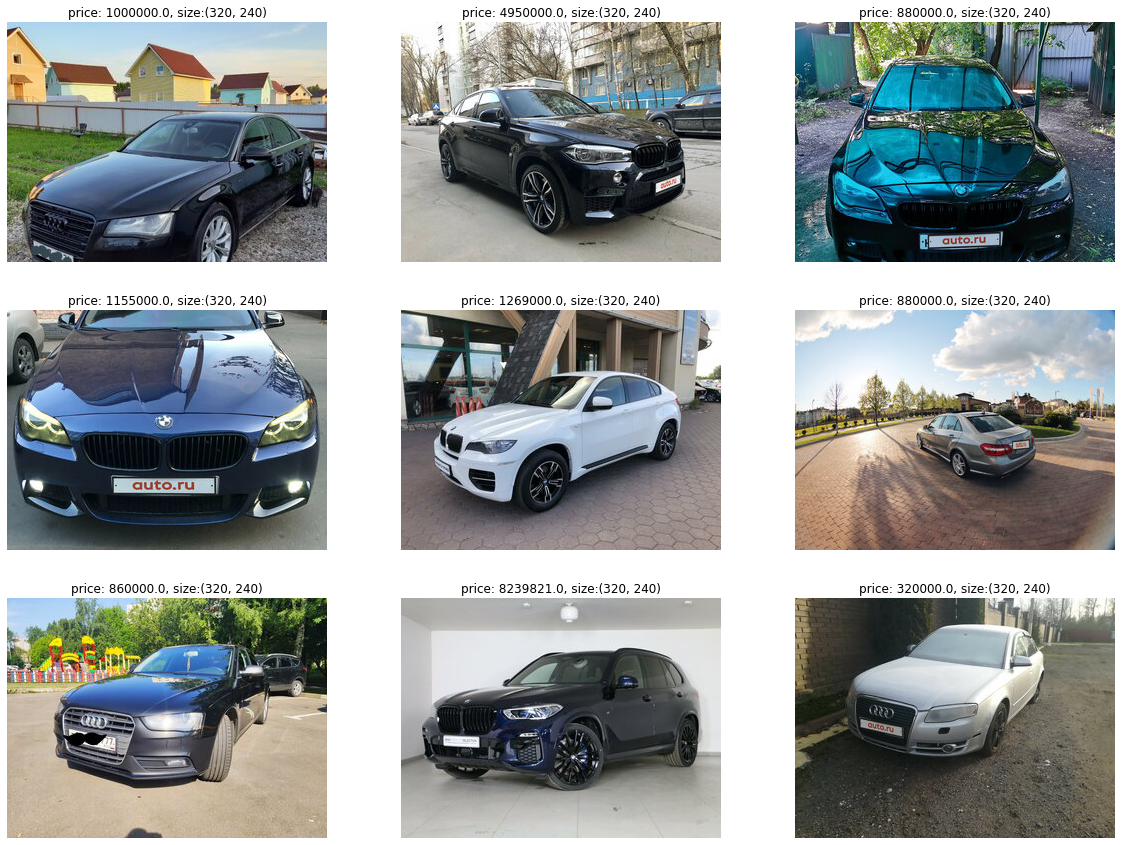

In [39]:
plt.figure(figsize = (20,15))

random_image = df_train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(path_img + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]) + ', size:' + str(im.size))
    plt.axis('off')
plt.show()

In [40]:
size = (320, 240)

def get_image_array(df):
    
    images_train = []
    for sell_id in tqdm(df.values):
        image = cv2.imread(path_img + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
        
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train_img)
images_valid = get_image_array(X_valid_img)
images_test = get_image_array(X_test_img)

100%|██████████| 5345/5345 [00:38<00:00, 140.54it/s]


images shape (5345, 240, 320, 3) dtype uint8


100%|██████████| 1337/1337 [00:08<00:00, 161.94it/s]


images shape (1337, 240, 320, 3) dtype uint8


100%|██████████| 1671/1671 [00:10<00:00, 160.13it/s]


images shape (1671, 240, 320, 3) dtype uint8


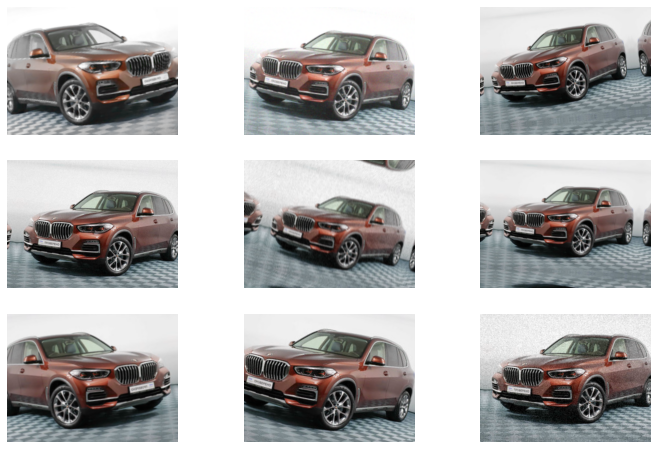

In [41]:
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [42]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [ ]:
x = make_augmentations(images_train)

применение аугментаций..........................

## Обучение модели

In [ ]:
model_nlp = Sequential([
    Embedding(num_words, 32, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(256, return_sequences=True),
    Dropout(0.5),
    LSTM(128,),
    Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25)])

In [ ]:
# создаем модель
model_mlp = Sequential([Dense(512, input_dim=X_train.shape[1], activation="relu"),
                    Dropout(0.5),
                    BatchNormalization(), 
                    Dense(256, activation="relu"),
                    Dropout(0.5),
                    Dense(1, activation="linear")])


In [ ]:
combinedInput = concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = Dense(64, activation="relu")(combinedInput)
head = Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)


In [ ]:
model.summary()

In [ ]:
optimizer = Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(path_data +'/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([X_train_text_num, X_train], Y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_valid_text_num, X_valid], Y_valid),
                    callbacks=callbacks_list
                   )


In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();


In [ ]:
model.load_weights(path_data +'/best_model.hdf5')
#model.save('../working/nn_1.hdf5')

In [ ]:
y_valid_predict = model.predict([X_valid_text_num, X_valid])
print(f"TEST mape: {(mean_absolute_percentage_error(Y_valid, y_valid_predict[:,0]))*100:0.2f}%")

## Предсказание

In [ ]:
# предсказываем результат 
y_test_predict = model.predict([X_test_text_num, X_test])

In [ ]:
y_test_predict

In [ ]:
#y_test_predict = np.exp(y_test_predict)

In [ ]:
submission = pd.read_csv(path_data+'sample_submission.csv')
submission['price'] = y_test_predict
submission.to_csv(path_data+'sample_submission_nn_with_text.csv', index=False)

In [ ]:
submission